In [135]:
import pybedtools
import pyranges

gencode = pyranges.read_gtf("../data/gencode.v40.basic.annotation.gtf")
gm12878_chromatin_states = pybedtools.BedTool("../data/rnaseq/ENCFF338RIC.bed").to_dataframe()
h1esc_chromatin_states = pybedtools.BedTool("../data/rnaseq/ENCFF323HNB.bed").to_dataframe()
hffc6_chromatin_states = pybedtools.BedTool("../data/rnaseq/ENCFF393FSC.bed").to_dataframe()

active_gene_states = ['TssA', 'TssAFlnk', 'TxFlnk', 'Tx', 'TxWk', 'EnhG', 'EnhG1', 'EnhG2', 'Enh', 'EnhA1', 'EnhA2']

In [136]:
# cut .xx postfix from gene_id
# gencode['gene_id'] = gencode['gene_id'].str.split('.')[0]
genes_from_gencode = (
    gencode
    [(gencode['Feature'] == 'gene') & (gencode['gene_type'] == 'protein_coding')]
    [['Chromosome', 'Start', 'End', 'gene_id']]
)

genes_from_gencode['gene_id'] = genes_from_gencode['gene_id'].str.split('.').str[0]

genes_from_gencode

,Chromosome,Start,End,gene_id
54,chr1,65418,71585,ENSG00000186092
176,chr1,450739,451678,ENSG00000284733
241,chr1,685715,686654,ENSG00000284662
454,chr1,923922,944575,ENSG00000187634
554,chr1,944202,959309,ENSG00000188976
...,...,...,...,...
1926870,chrM,10469,10766,ENSG00000212907
1926877,chrM,10759,12137,ENSG00000198886
1926891,chrM,12336,14148,ENSG00000198786
1926897,chrM,14148,14673,ENSG00000198695


In [137]:
import pandas as pd

distances_with_links_exp4 = pd.read_parquet("./links/experiment_4/distances_with_links.parquet").rename({"dist_avg_dist": "avg_dist"}, axis=1)
distances_with_links_exp5 = pd.read_parquet("./links/experiment_5/distances_with_links.parquet").rename({"dist_avg_dist": "avg_dist"}, axis=1)
distances_with_links = pd.concat([distances_with_links_exp4, distances_with_links_exp5], ignore_index=True)

gm12878_neanderthal_df_ref = distances_with_links[distances_with_links['cell_line'] == 'GM12878']
hffc6_neanderthal_df_ref = distances_with_links[distances_with_links['cell_line'] == 'HFFC6']
h1esc_neanderthal_df_ref = distances_with_links[distances_with_links['cell_line'] == 'H1ESC']

In [138]:
distance_cutoff = {
    'H1ESC_Nean': 1.5819487888988626,
    'H1ESC_Deni': 1.5940225214185284,
    'HFFC6_Nean': 1.4982763183612486,
    'HFFC6_Deni': 1.7777412978743463,
    'WTC11_Nean': 0.49185075802354294,
    'WTC11_Deni': 0.49946283771094635,
    'GM12878_Nean': 1.3194976373807719,
    'GM12878_Deni': 1.2678860440889042
}

gm12878_neanderthal_df_ref = gm12878_neanderthal_df_ref[gm12878_neanderthal_df_ref["avg_dist"] > distance_cutoff["GM12878_Nean"]]
hffc6_neanderthal_df_ref = hffc6_neanderthal_df_ref[hffc6_neanderthal_df_ref["avg_dist"] > distance_cutoff["HFFC6_Nean"]]
h1esc_neanderthal_df_ref = h1esc_neanderthal_df_ref[h1esc_neanderthal_df_ref["avg_dist"] > distance_cutoff["H1ESC_Nean"]]

In [139]:
# Attach gene coordinates to the distances, split enh_id (chrX:12345-67890) into chromosome, start, end
gm12878_neanderthal_df_ref = (
    gm12878_neanderthal_df_ref
    .merge(genes_from_gencode, left_on='gene_id', right_on='gene_id', how='left', suffixes=('', '_gene'))
    .rename({'Chromosome': 'gene_chromosome', 'Start': 'gene_start', 'End': 'gene_end'}, axis=1)
)
gm12878_neanderthal_df_ref[['enh_chromosome', 'enh_start', 'enh_end']] = gm12878_neanderthal_df_ref['enh_id'].str.split(':|-', expand=True)
gm12878_neanderthal_df_ref['enh_start'] = gm12878_neanderthal_df_ref['enh_start'].astype(int)
gm12878_neanderthal_df_ref['enh_end'] = gm12878_neanderthal_df_ref['enh_end'].astype(int)

hffc6_neanderthal_df_ref = (
    hffc6_neanderthal_df_ref
    .merge(genes_from_gencode, left_on='gene_id', right_on='gene_id', how='left', suffixes=('', '_gene'))
    .rename({'Chromosome': 'gene_chromosome', 'Start': 'gene_start', 'End': 'gene_end'}, axis=1)
)
hffc6_neanderthal_df_ref[['enh_chromosome', 'enh_start', 'enh_end']] = hffc6_neanderthal_df_ref['enh_id'].str.split(':|-', expand=True)
hffc6_neanderthal_df_ref['enh_start'] = hffc6_neanderthal_df_ref['enh_start'].astype(int)
hffc6_neanderthal_df_ref['enh_end'] = hffc6_neanderthal_df_ref['enh_end'].astype(int)

h1esc_neanderthal_df_ref = (
    h1esc_neanderthal_df_ref
    .merge(genes_from_gencode, left_on='gene_id', right_on='gene_id', how='left', suffixes=('', '_gene'))
    .rename({'Chromosome': 'gene_chromosome', 'Start': 'gene_start', 'End': 'gene_end'}, axis=1)
)
h1esc_neanderthal_df_ref[['enh_chromosome', 'enh_start', 'enh_end']] = h1esc_neanderthal_df_ref['enh_id'].str.split(':|-', expand=True)
h1esc_neanderthal_df_ref['enh_start'] = h1esc_neanderthal_df_ref['enh_start'].astype(int)
h1esc_neanderthal_df_ref['enh_end'] = h1esc_neanderthal_df_ref['enh_end'].astype(int)

In [140]:
def mark_active_regions(df, chromatin_states_df, active_gene_states):
    # Create PyRanges for active regions
    active_regions_pr = pyranges.PyRanges(
        {
            "Chromosome": chromatin_states_df['chrom'][chromatin_states_df['name'].isin(active_gene_states)],
            "Start": chromatin_states_df['start'][chromatin_states_df['name'].isin(active_gene_states)],
            "End": chromatin_states_df['end'][chromatin_states_df['name'].isin(active_gene_states)]
        }
    )

    # Create PyRanges objects for genes and enhancers with index as identifier
    genes_pr = pyranges.PyRanges(
        {
            "Chromosome": df['gene_chromosome'],
            "Start": df['gene_start'],
            "End": df['gene_end'],
            "row_id": df.index
        }
    )

    enhancers_pr = pyranges.PyRanges(
        {
            "Chromosome": df['enh_chromosome'],
            "Start": df['enh_start'],
            "End": df['enh_end'],
            "row_id": df.index
        }
    )

    # Find genes and enhancers that overlap with active regions
    active_genes = genes_pr.intersect(active_regions_pr)
    active_enhancers = enhancers_pr.intersect(active_regions_pr)

    # Get sets of row IDs where genes and enhancers are active
    active_gene_rows = set(active_genes['row_id']) if not active_genes.empty else set()
    active_enhancer_rows = set(active_enhancers['row_id']) if not active_enhancers.empty else set()

    # Find rows where both gene and enhancer are active (intersection of sets)
    active_rows = active_gene_rows.intersection(active_enhancer_rows)

    # Create a copy of the input dataframe with the is_active column added
    result_df = df.copy()
    result_df['is_active'] = result_df.index.isin(active_rows)

    return result_df

gm12878_neanderthal_df_ref = mark_active_regions(gm12878_neanderthal_df_ref, gm12878_chromatin_states, active_gene_states)
gm12878_neanderthal_df_ref = gm12878_neanderthal_df_ref[gm12878_neanderthal_df_ref['is_active']].drop(columns=['is_active'])

hffc6_neanderthal_df_ref = mark_active_regions(hffc6_neanderthal_df_ref, hffc6_chromatin_states, active_gene_states)
hffc6_neanderthal_df_ref = hffc6_neanderthal_df_ref[hffc6_neanderthal_df_ref['is_active']].drop(columns=['is_active'])

h1esc_neanderthal_df_ref = mark_active_regions(h1esc_neanderthal_df_ref, h1esc_chromatin_states, active_gene_states)
h1esc_neanderthal_df_ref = h1esc_neanderthal_df_ref[h1esc_neanderthal_df_ref['is_active']].drop(columns=['is_active'])

In [141]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

with open("../data/rnaseq/gm12878_read_count.txt", "r") as f:
    # Skip the first line
    f.readline()
    gm12878_counts_df = pd.read_csv(f, index_col=0, sep="\t")


with open("../data/rnaseq/h1esc_read_count.txt", "r") as f:
    # Skip the first line
    f.readline()
    h1esc_counts_df = pd.read_csv(f, index_col=0, sep="\t")

with open("../data/rnaseq/hffc6_read_count.txt", "r") as f:
    # Skip the first line
    f.readline()
    hffc6_counts_df = pd.read_csv(f, index_col=0, sep="\t")

gm12878_counts_df = gm12878_counts_df[['ENCFF800HIP.filtered.bam', 'ENCFF991KKX.filtered.bam']].T
h1esc_counts_df = h1esc_counts_df[['ENCFF675NTU.filtered.bam', 'ENCFF379NOY.filtered.bam']].T
hffc6_counts_df = hffc6_counts_df[['ENCFF307KUI.filtered.bam', 'ENCFF294BSI.filtered.bam', 'ENCFF937TEI.filtered.bam']].T

def compute_deseq_stats_for_2_celllines(cellline1_counts_df, cellline2_counts_df, cellline1_name="CellLine1", cellline2_name="CellLine2"):
    cl1_vs_cl2_counts_df = pd.concat(
        [cellline1_counts_df, cellline2_counts_df]
    )

    cl1_vs_cl2_metadata_df = pd.DataFrame(
        {
            "condition": [cellline1_name] * cellline1_counts_df.shape[0] + [cellline2_name] * cellline2_counts_df.shape[0]
        },
        index=cl1_vs_cl2_counts_df.index,
    )

    inference = DefaultInference(n_cpus=8)
    dds = DeseqDataSet(
        counts=cl1_vs_cl2_counts_df,
        metadata=cl1_vs_cl2_metadata_df,
        design="~condition",
        refit_cooks=True,
        inference=inference,
    )

    dds.deseq2()
    stats = DeseqStats(dds, contrast=["condition", cellline2_name, cellline1_name])
    stats.summary()

    results_df = stats.results_df.dropna()
    results_df['symbol'] = results_df.index
    return results_df

gm12878_vs_h1esc_results_df = compute_deseq_stats_for_2_celllines(
    gm12878_counts_df,
    h1esc_counts_df,
    cellline1_name="GM12878",
    cellline2_name="H1ESC"
)

h1esc_vs_hffc6_results_df = compute_deseq_stats_for_2_celllines(
    h1esc_counts_df,
    hffc6_counts_df,
    cellline1_name="H1ESC",
    cellline2_name="HFFC6"
)

hffc6_vs_gm12878_results_df = compute_deseq_stats_for_2_celllines(
    hffc6_counts_df,
    gm12878_counts_df,
    cellline1_name="HFFC6",
    cellline2_name="GM12878"
)

Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 1.07 seconds.

Fitting dispersion trend curve...
... done in 0.37 seconds.

/opt/anaconda3/envs/enhancer3D/lib/python3.13/site-packages/pydeseq2/dds.py:542: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 1.69 seconds.

Fitting LFCs...
... done in 1.32 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 1.95 seconds.

/var/folders/ss/9hx8q7517rzf6x75cfny7ndc0000gp/T/ipykernel_55155/2862106465.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Log2 fold change & Wald test p-value: condition H1ESC vs GM12878
                       baseMean  log2FoldChange     lfcSE      stat  \
Geneid                                                                
ENSG00000223972.5      0.000000             NaN       NaN       NaN   
ENSG00000227232.5      0.000000             NaN       NaN       NaN   
ENSG00000278267.1      2.248036        0.506469  1.823320  0.277773   
ENSG00000243485.5      0.000000             NaN       NaN       NaN   
ENSG00000284332.1      0.000000             NaN       NaN       NaN   
...                         ...             ...       ...       ...   
ENSG00000198695.2   2048.736260        0.437514  0.086208  5.075096   
ENSG00000210194.1     23.651924       -0.576258  0.577638 -0.997612   
ENSG00000198727.2  38697.120986       -0.371529  0.058147 -6.389494   
ENSG00000210195.2     89.769900       -1.306326  0.306061 -4.268188   
ENSG00000210196.2     98.976794       -0.069780  0.282614 -0.246908   

           

Fitting size factors...
... done in 0.01 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 1.12 seconds.

Fitting dispersion trend curve...
... done in 0.38 seconds.

/opt/anaconda3/envs/enhancer3D/lib/python3.13/site-packages/pydeseq2/dds.py:542: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 1.63 seconds.

Fitting LFCs...
... done in 1.20 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 1.72 seconds.

/var/folders/ss/9hx8q7517rzf6x75cfny7ndc0000gp/T/ipykernel_55155/2862106465.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  re

Log2 fold change & Wald test p-value: condition HFFC6 vs H1ESC
                       baseMean  log2FoldChange     lfcSE      stat  \
Geneid                                                                
ENSG00000223972.5      0.000000             NaN       NaN       NaN   
ENSG00000227232.5      4.548690        5.383865  2.586318  2.081671   
ENSG00000278267.1      1.372396       -1.891656  2.006040 -0.942980   
ENSG00000243485.5      0.000000             NaN       NaN       NaN   
ENSG00000284332.1      0.000000             NaN       NaN       NaN   
...                         ...             ...       ...       ...   
ENSG00000198695.2   1669.869168       -0.718368  0.150894 -4.760729   
ENSG00000210194.1     12.167266       -1.037633  0.679102 -1.527948   
ENSG00000198727.2  25784.760948       -0.497953  0.193864 -2.568560   
ENSG00000210195.2    106.491115        1.604338  0.280161  5.726478   
ENSG00000210196.2     64.532522       -0.902914  0.328352 -2.749838   

             

Fitting size factors...
... done in 0.01 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 1.34 seconds.

Fitting dispersion trend curve...
... done in 0.36 seconds.

/opt/anaconda3/envs/enhancer3D/lib/python3.13/site-packages/pydeseq2/dds.py:542: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 1.55 seconds.

Fitting LFCs...
... done in 1.24 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...


Log2 fold change & Wald test p-value: condition GM12878 vs HFFC6
                       baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Geneid                                                                          
ENSG00000223972.5      0.000000             NaN       NaN       NaN       NaN   
ENSG00000227232.5      4.876008       -5.631698  2.581318 -2.181715  0.029131   
ENSG00000278267.1      1.138906        1.341493  2.194531  0.611289  0.541008   
ENSG00000243485.5      0.000000             NaN       NaN       NaN       NaN   
ENSG00000284332.1      0.000000             NaN       NaN       NaN       NaN   
...                         ...             ...       ...       ...       ...   
ENSG00000198695.2   1520.630326        0.231177  0.157710  1.465835  0.142693   
ENSG00000210194.1     16.391290        1.564962  0.603404  2.593556  0.009499   
ENSG00000198727.2  30956.220844        0.819239  0.191453  4.279060  0.000019   
ENSG00000210195.2    142.558092       -0.348

... done in 1.43 seconds.

/var/folders/ss/9hx8q7517rzf6x75cfny7ndc0000gp/T/ipykernel_55155/2862106465.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df['symbol'] = results_df.index


In [142]:

gm12878_gene_to_closest_avg_enhancer_all = (
    gm12878_neanderthal_df_ref
    .groupby("gene_id")
    .agg(
        avg_dist=("avg_dist", "mean"),
        min_dist=("avg_dist", "min"),
        max_dist=("avg_dist", "max"),
    )
    .sort_values(by="avg_dist", ascending=True)
)
gm12878_gene_to_closest_avg_enhancer_all['has_link'] = (
    gm12878_gene_to_closest_avg_enhancer_all.index
    .isin(gm12878_neanderthal_df_ref[gm12878_neanderthal_df_ref["has_link"] == True]["gene_id"].unique())
)

hffc6_gene_to_closest_avg_enhancer_all = (
    hffc6_neanderthal_df_ref
    .groupby("gene_id")
    .agg(
        avg_dist=("avg_dist", "mean"),
        min_dist=("avg_dist", "min"),
        max_dist=("avg_dist", "max"),
    )
    .sort_values(by="avg_dist", ascending=True)
)

hffc6_gene_to_closest_avg_enhancer_all['has_link'] = (
    hffc6_gene_to_closest_avg_enhancer_all.index
    .isin(hffc6_neanderthal_df_ref[hffc6_neanderthal_df_ref["has_link"] == True]["gene_id"].unique())
)

h1esc_gene_to_closest_avg_enhancer_all = (
    h1esc_neanderthal_df_ref
    .groupby("gene_id")
    .agg(
        avg_dist=("avg_dist", "mean"),
        min_dist=("avg_dist", "min"),
        max_dist=("avg_dist", "max"),
    )
    .sort_values(by="avg_dist", ascending=True)
)

h1esc_gene_to_closest_avg_enhancer_all['has_link'] = (
    h1esc_gene_to_closest_avg_enhancer_all.index
    .isin(h1esc_neanderthal_df_ref[h1esc_neanderthal_df_ref["has_link"] == True]["gene_id"].unique())
)

for df, name in [
    (gm12878_gene_to_closest_avg_enhancer_all, 'gm12878'),
    (hffc6_gene_to_closest_avg_enhancer_all, 'hffc6'),
    (h1esc_gene_to_closest_avg_enhancer_all, 'h1esc'),
]:
    q1 = df['min_dist'].quantile(0.33)
    q3 = df['min_dist'].quantile(0.66)
    def label_quartile(x):
        if x <= q1:
            return 'small'
        elif x <= q3:
            return 'mid'
        else:
            return 'large'
    df['quartile_cat'] = df['min_dist'].apply(label_quartile)

In [143]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import numpy as np
import joypy
from matplotlib import cm

def plot_distance_vs_expression_correlation(
    cell1_distances_df,
    cell2_distances_df,
    deseq_results_df,
    cell1_name,
    cell2_name,
    figsize=(20, 20),
    plot_path=None,
    color_map=cm.viridis,
    font_size=18,
    log2fc_threshold=2,
    padj_threshold=0.05
):
    deseq_results_df = deseq_results_df.copy()

    # Cut .xx from gene index of
    deseq_results_df.index = deseq_results_df.index.str.split('.').str[0]

    deseq_results_df = deseq_results_df[
        (deseq_results_df["padj"] < padj_threshold)
        & (deseq_results_df["log2FoldChange"].abs() > log2fc_threshold)
    ]

    # Normalize all distances against average distance
    cell1_distances_df = cell1_distances_df.copy()
    cell1_distances_df['norm_min_dist'] = (
        (cell1_distances_df['min_dist'] - cell1_distances_df['min_dist'].min()) / (cell1_distances_df['min_dist'].max() - cell1_distances_df['min_dist'].min())
    )

    cell2_distances_df = cell2_distances_df.copy()
    cell2_distances_df['norm_min_dist'] = (
        (cell2_distances_df['min_dist'] - cell2_distances_df['min_dist'].min()) / (cell2_distances_df['min_dist'].max() - cell2_distances_df['min_dist'].min())
    )

    # Join the two distance dataframes
    combined_df = cell1_distances_df.merge(
        cell2_distances_df,
        left_index=True,
        right_index=True,
        how="inner",
        suffixes=(f"_{cell1_name}", f"_{cell2_name}")
    )

    # Calculate min_dist change (log ratio for better scaling)
    combined_df["log_dist_ratio"] = np.log2(combined_df[f"min_dist_{cell2_name}"] / combined_df[f"min_dist_{cell1_name}"])
    combined_df["dist_diff"] = combined_df[f"min_dist_{cell2_name}"] - combined_df[f"min_dist_{cell1_name}"]

    combined_df["norm_dist_diff"] = combined_df[f"norm_min_dist_{cell2_name}"] - combined_df[f"norm_min_dist_{cell1_name}"]
    combined_df["log_norm_dist_ratio"] = np.log2(combined_df[f"norm_min_dist_{cell2_name}"] / combined_df[f"norm_min_dist_{cell1_name}"])

    # Define link change categories
    def get_link_change(row):
        if row[f"has_link_{cell1_name}"] and not row[f"has_link_{cell2_name}"]:
            return f"Only {cell1_name}"
        elif not row[f"has_link_{cell1_name}"] and row[f"has_link_{cell2_name}"]:
            return f"Only {cell2_name}"
        elif row[f"has_link_{cell1_name}"] and row[f"has_link_{cell2_name}"]:
            return "Both"
        else:
            return "Neither"

    combined_df["link_status"] = combined_df.apply(get_link_change, axis=1)

    # Define quartile change categories
    def get_quartile_change(row):
        q1 = row[f"quartile_cat_{cell1_name}"]
        q2 = row[f"quartile_cat_{cell2_name}"]

        if q1 == q2:
            return "No change"

        categories = ["small", "mid", "large"]
        idx1 = categories.index(q1)
        idx2 = categories.index(q2)

        if idx1 > idx2:
            return f"Decreased ({q1} to {q2})"
        else:
            return f"Increased ({q1} to {q2})"

    combined_df["quartile_change"] = combined_df.apply(get_quartile_change, axis=1)

    # Merge with DESeq2 results
    merged_df = combined_df.merge(
        deseq_results_df[["log2FoldChange", "padj"]],
        left_index=True,
        right_index=True,
        how="inner"
    )

    merged_df_for_correlation = merged_df.copy()
    # Filter out insignificant changes in quartile change
    merged_df_for_correlation = merged_df_for_correlation[
        ~merged_df_for_correlation["quartile_change"].isin([
            "No change",
            "Increased (small to mid)",
            "Increased (mid to large)",
            "Decreased (large to mid)",
            "Decreased (mid to small)",
        ])
    ]

    merged_df_for_plotting = merged_df.copy()
    merged_df_for_plotting = merged_df_for_plotting[
        ~merged_df_for_plotting["quartile_change"].isin([
            "Increased (small to mid)",
            "Increased (mid to large)",
            "Decreased (large to mid)",
            "Decreased (mid to small)",
        ])
    ]

    # Calculate and display correlation
    # pearson_r, pearson_p = pearsonr(merged_df_for_correlation["log_dist_ratio"], merged_df_for_correlation["log2FoldChange"], alternative='two-sided') - data is not normally distributed
    spearman_r, spearman_p = spearmanr(merged_df_for_correlation["log_dist_ratio"], merged_df_for_correlation["log2FoldChange"], alternative='two-sided')

    # Plot: Log2 fold change by quartile change
    # Define order for visualization
    quartile_order = [
        "Increased (small to large)",
        # "Increased (mid to large)",
        # "Increased (small to mid)",
        "No change",
        "Decreased (large to small)",
        # "Decreased (mid to small)",
        # "Decreased (large to mid)"
    ]

    # Filter out empty categories
    available_categories = merged_df_for_plotting["quartile_change"].unique()
    plot_order = [cat for cat in quartile_order if cat in available_categories]

    # Create plot data dictionary
    plot_data = {}
    for category in plot_order:
        subset = merged_df_for_plotting[merged_df_for_plotting["quartile_change"] == category]
        if len(subset) >= 3:  # Minimum data points for KDE
            plot_data[category] = subset["log2FoldChange"]

    # Create figure
    fig, axes = joypy.joyplot(
        plot_data,
        figsize=figsize,
        colormap=color_map,
        overlap=0.7,
        linewidth=1,
        alpha=0.8,
        grid="y",
        legend=False,
        title=f"Expression Change by Distance Change for {cell1_name} vs {cell2_name}\n" +
              # f"Pearson r: {pearson_r:.3f} (p: {pearson_p:.2e}) | " +
              f"Spearman r: {spearman_r:.3f} (p: {spearman_p:.2e})",
        range_style='own',

    )

    # print(f'Pearson r: {pearson_r:.3f}, p-value: {pearson_p:.2e}')
    print(f'Spearman r: {spearman_r:.3f}, p-value: {spearman_p:.2e}')

    # Customize plot
    plt.xlabel("Log2 Fold Change", fontsize=font_size)

    # Add gray vertical lines at log2FC = 0
    for ax in axes[:-1]:  # Skip the last ax which is just for the x-axis
        ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5, linewidth=1)

    # Add vertical lines at log2FC = -1 and log2FC = 1 to each subplot
    for ax in axes[:-1]:  # Skip the last ax which is just for the x-axis
        ax.axvline(x=-log2fc_threshold, color='gray', linestyle='--', alpha=0.7, linewidth=1)
        ax.axvline(x=log2fc_threshold, color='gray', linestyle='--', alpha=0.7, linewidth=1)

    title = axes[-1].get_title()
    axes[-1].set_title(title, fontsize=font_size)
    for ax in axes:
        label = ax.get_yticklabels()
        ax.set_yticklabels(label, fontsize=font_size)
    # # Add red vertical link at mean of log2FoldChange for each quartile change
    # for ax, category in zip(axes[:-1], plot_order):
    #     if category in plot_data:
    #         mean_value = plot_data[category].mean()
    #         ax.axvline(x=mean_value, color='red', linestyle='-', alpha=0.7, linewidth=1)

    # Add legend with better position
    handles = []
    for i, label in enumerate(plot_data.keys()):
        color = color_map(i / len(plot_data))
        handles.append(plt.Rectangle((0,0), 1, 1, color=color, alpha=0.7))

    # Add threshold lines to legend
    handles.append(plt.Line2D([0], [0], color='gray', linestyle='--', alpha=0.7))
    legend_labels = list(plot_data.keys()) + [f'Significance threshold (|log2FC| > {log2fc_threshold})']

    # handles.append(plt.Line2D([0], [0], color='red', linestyle='-', alpha=0.7))
    # legend_labels.append('Mean log2FC for each quartile change')

    plt.figlegend(
        handles, legend_labels,
        loc="upper left",
        bbox_to_anchor=(0.99, 0.98),
        title="Quartile Change",
        fontsize=font_size,
    )

    if plot_path:
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    else:
        plt.tight_layout()

    return fig, merged_df

Spearman r: -0.507, p-value: 8.86e-11


/opt/anaconda3/envs/enhancer3D/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/ss/9hx8q7517rzf6x75cfny7ndc0000gp/T/ipykernel_55155/2142058160.py:182: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(label, fontsize=font_size)


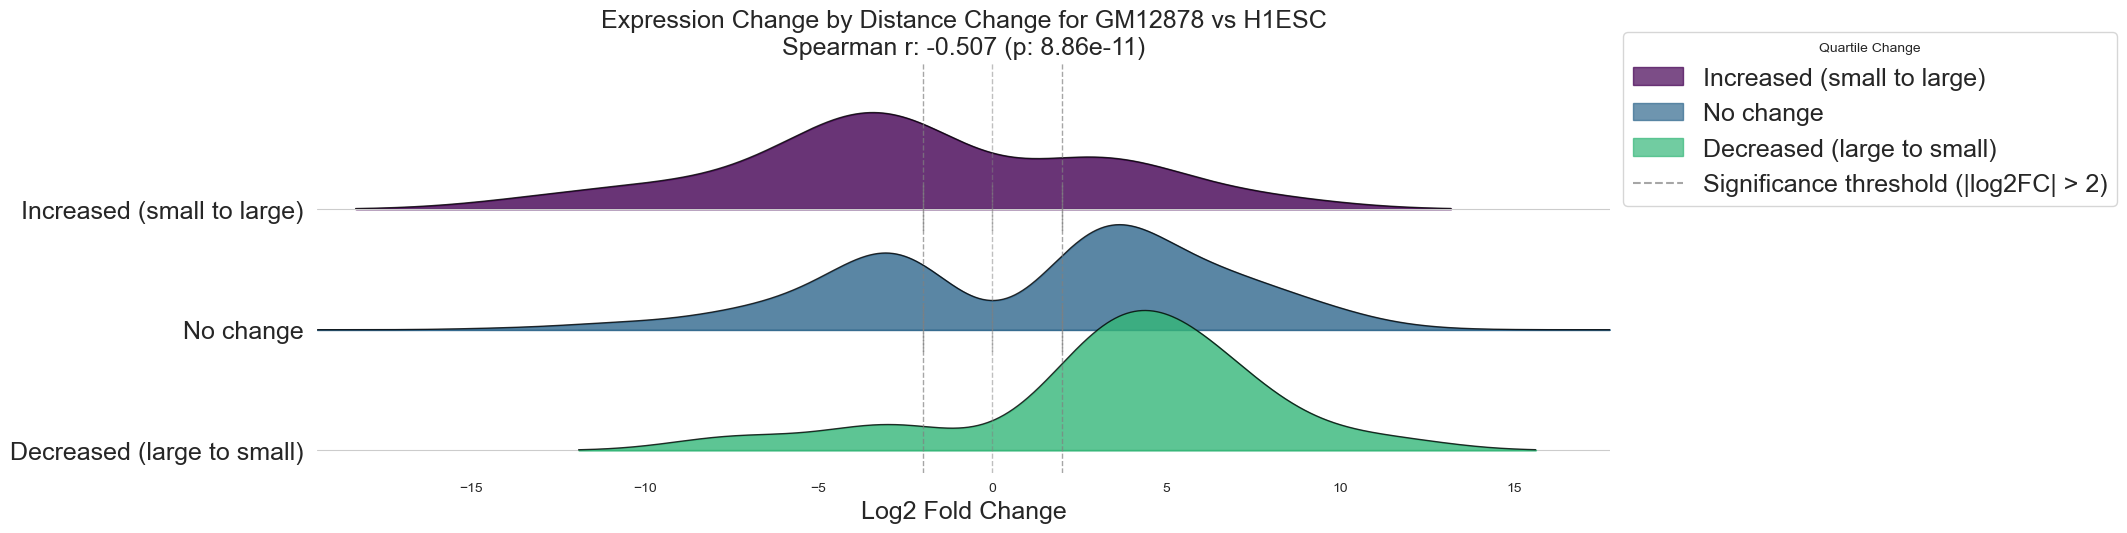

In [144]:
# Example usage
fig, corr_data = plot_distance_vs_expression_correlation(
    gm12878_gene_to_closest_avg_enhancer_all,
    h1esc_gene_to_closest_avg_enhancer_all,
    gm12878_vs_h1esc_results_df,
    "GM12878",
    "H1ESC",
    figsize=(15, 5),
    plot_path="figs/exp4_gm_h1_joy.png"
)
plt.show()

Spearman r: -0.550, p-value: 6.69e-13


/opt/anaconda3/envs/enhancer3D/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/ss/9hx8q7517rzf6x75cfny7ndc0000gp/T/ipykernel_55155/2142058160.py:182: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(label, fontsize=font_size)


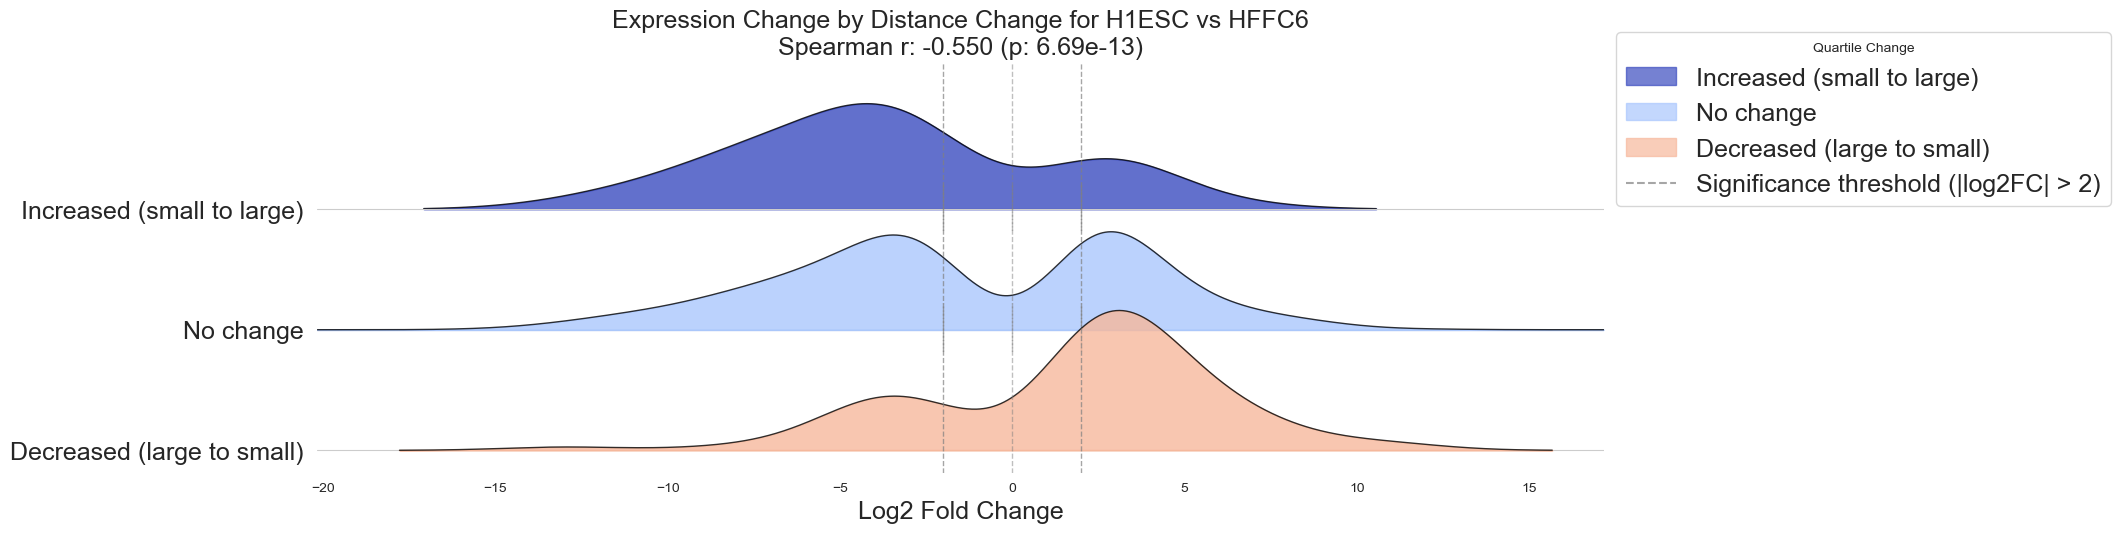

In [145]:
fig, corr_data = plot_distance_vs_expression_correlation(
    h1esc_gene_to_closest_avg_enhancer_all,
    hffc6_gene_to_closest_avg_enhancer_all,
    h1esc_vs_hffc6_results_df,
    "H1ESC",
    "HFFC6",
    figsize=(15, 5),
    plot_path="figs/exp4_h1_hffc_joy.png",
    color_map=cm.coolwarm
)

plt.show()

Spearman r: -0.644, p-value: 5.36e-16


/opt/anaconda3/envs/enhancer3D/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/ss/9hx8q7517rzf6x75cfny7ndc0000gp/T/ipykernel_55155/2142058160.py:182: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(label, fontsize=font_size)


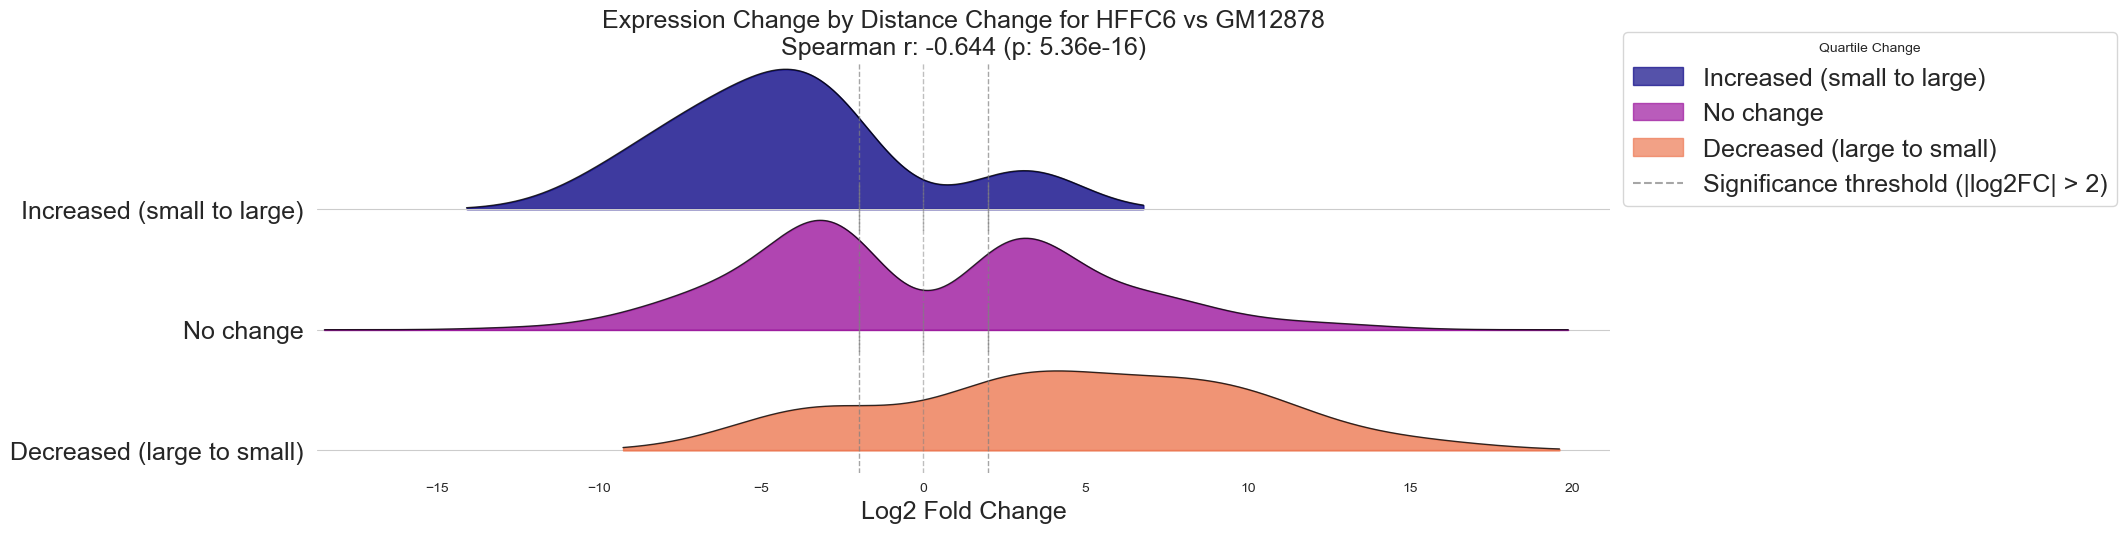

In [146]:
fig, corr_data = plot_distance_vs_expression_correlation(
    hffc6_gene_to_closest_avg_enhancer_all,
    gm12878_gene_to_closest_avg_enhancer_all,
    hffc6_vs_gm12878_results_df,
    "HFFC6",
    "GM12878",
    figsize=(15, 5),
    plot_path="figs/exp4_hffc_gm_joy.png",
    color_map=cm.plasma
)

plt.show()

In [147]:
import matplotlib.pyplot as plt
import numpy as np
from gprofiler import GProfiler

gp = GProfiler(
    user_agent='enhancer3d', #optional user agent
    return_dataframe=True, #return pandas dataframe or plain python structures
)

def get_genes_from_2_cell_lines(
    cell1_distances_df,
    cell2_distances_df,
    deseq_results_df,
    cell1_name,
    cell2_name,
    log2fc_threshold=2,
    padj_threshold=0.05
):
    deseq_results_df = deseq_results_df.copy()

    # Cut .xx from gene index of
    deseq_results_df.index = deseq_results_df.index.str.split('.').str[0]

    deseq_results_df = deseq_results_df[
        (deseq_results_df["padj"] < padj_threshold)
        & (deseq_results_df["log2FoldChange"].abs() > log2fc_threshold)
    ]

    # Normalize all distances against average distance
    cell1_distances_df = cell1_distances_df.copy()
    cell1_distances_df['norm_min_dist'] = (
        (cell1_distances_df['min_dist'] - cell1_distances_df['min_dist'].min()) / (cell1_distances_df['min_dist'].max() - cell1_distances_df['min_dist'].min())
    )

    cell2_distances_df = cell2_distances_df.copy()
    cell2_distances_df['norm_min_dist'] = (
        (cell2_distances_df['min_dist'] - cell2_distances_df['min_dist'].min()) / (cell2_distances_df['min_dist'].max() - cell2_distances_df['min_dist'].min())
    )

    # Join the two distance dataframes
    combined_df = cell1_distances_df.merge(
        cell2_distances_df,
        left_index=True,
        right_index=True,
        how="inner",
        suffixes=(f"_{cell1_name}", f"_{cell2_name}")
    )

    # Calculate min_dist change (log ratio for better scaling)
    combined_df["log_dist_ratio"] = np.log2(combined_df[f"min_dist_{cell1_name}"] / combined_df[f"min_dist_{cell2_name}"])
    combined_df["dist_diff"] = combined_df[f"min_dist_{cell1_name}"] - combined_df[f"min_dist_{cell2_name}"]

    combined_df["norm_dist_diff"] = combined_df[f"norm_min_dist_{cell1_name}"] - combined_df[f"norm_min_dist_{cell2_name}"]
    combined_df["log_norm_dist_ratio"] = np.log2(combined_df[f"norm_min_dist_{cell1_name}"] / combined_df[f"norm_min_dist_{cell2_name}"])

    # Define link change categories
    def get_link_change(row):
        if row[f"has_link_{cell1_name}"] and not row[f"has_link_{cell2_name}"]:
            return f"Only {cell1_name}"
        elif not row[f"has_link_{cell1_name}"] and row[f"has_link_{cell2_name}"]:
            return f"Only {cell2_name}"
        elif row[f"has_link_{cell1_name}"] and row[f"has_link_{cell2_name}"]:
            return "Both"
        else:
            return "Neither"

    combined_df["link_status"] = combined_df.apply(get_link_change, axis=1)

    # Define quartile change categories
    def get_quartile_change(row):
        q1 = row[f"quartile_cat_{cell1_name}"]
        q2 = row[f"quartile_cat_{cell2_name}"]

        if q1 == q2:
            return "No change"

        categories = ["small", "mid", "large"]
        idx1 = categories.index(q1)
        idx2 = categories.index(q2)

        if idx1 > idx2:
            return f"Decreased ({q1} to {q2})"
        else:
            return f"Increased ({q1} to {q2})"

    combined_df["quartile_change"] = combined_df.apply(get_quartile_change, axis=1)

    # Merge with DESeq2 results
    merged_df = combined_df.merge(
        deseq_results_df[["log2FoldChange", "padj"]],
        left_index=True,
        right_index=True,
        how="inner"
    )

    merged_df_for_correlation = merged_df.copy()
    # Filter out insignificant changes in quartile change
    merged_df_for_correlation = merged_df_for_correlation[
        ~merged_df_for_correlation["quartile_change"].isin([
            "No change",
            "Increased (small to mid)",
            "Increased (mid to large)",
            "Decreased (large to mid)",
            "Decreased (mid to small)",
        ])
    ]

    merged_df_for_genes = merged_df.copy()
    cell_line_1_upregulated_jumper_genes = merged_df_for_genes[
        (merged_df_for_genes["log2FoldChange"] < -log2fc_threshold)
        # & (merged_df_for_genes["link_status"] == f"Only {cell1_name}")
        & (merged_df_for_genes["quartile_change"].isin([
            "Increased (small to large)",
            "Increased (mid to small)",
            "Increased (mid to large)",
        ]))
    ].index

    cell_line_2_upregulated_jumper_genes = merged_df_for_genes[
        (merged_df_for_genes["log2FoldChange"] > log2fc_threshold)
        # & (merged_df_for_genes["link_status"] == f"Only {cell2_name}")
        & (merged_df_for_genes["quartile_change"].isin([
            "Decreased (small to large)",
            "Decreased (mid to small)",
            "Decreased (mid to large)",
        ]))
    ].index

    gene_names_cell_line_1 = (
        gp
        .convert(
            organism='hsapiens',
            query=cell_line_1_upregulated_jumper_genes.tolist(),
        )
        [['converted', 'name']]
        .set_index('converted', drop=True)
    )

    gene_names_cell_line_2 = (
        gp
        .convert(
            organism='hsapiens',
            query=cell_line_2_upregulated_jumper_genes.tolist(),
        )
        [['converted', 'name']]
        .set_index('converted', drop=True)
    )

    return gene_names_cell_line_1['name'].tolist(), gene_names_cell_line_2['name'].tolist(), merged_df_for_genes

In [189]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import seaborn as sns
from textwrap import wrap
import gseapy

def get_enrichment_results(gene_list, gene_sets):
    """
    Get enrichment results for a given gene list using gseapy.
    """
    enr = gseapy.enrichr(
        gene_list=gene_list,
        gene_sets=gene_sets,
        organism='Human',
        outdir=None,
        cutoff=0.05
    )

    results = enr.results[['Term', 'P-value', 'Adjusted P-value', 'Overlap', 'Combined Score', 'Genes']]
    results = results.sort_values(by='Combined Score', ascending=False).head(10)
    results['Genes Ratio'] = results['Genes'].apply(lambda x: len(x.split(';')) / len(gene_list))
    results['Genes Number'] = results['Genes'].apply(lambda x: len(x.split(';')))
    return results.reset_index(drop=True)

def dotplot(
    results,
    figsize=(15, 8),
    fontsize=24,
    title="Enrichment Results",
    xlabel="Combined Score",
    ylabel="Term",
    plot_path=None,
    palette=sns.mpl_palette("spring", as_cmap=True)
):
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(
        data=results,
        x='Combined Score',
        y='Term',
        hue='Adjusted P-value',
        hue_norm=(0, 1),
        palette=palette,
        ax=ax,
        legend=False,
    )

    norm = Normalize(vmin=0, vmax=1)
    sm = ScalarMappable(cmap=palette, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, label='Adjusted P-value', shrink=0.8)
    cbar.ax.tick_params(labelsize=fontsize-2)
    cbar.set_label('Adjusted P-value', fontsize=fontsize, labelpad=10)

    # handles, labels = ax.get_legend_handles_labels()
    # size_legend = ax.legend(
    #     handles=handles[:len(handles)//2],
    #     labels=labels[:len(labels)//2],
    #     title='Combined Score',
    #     bbox_to_anchor=(1.05, 1),
    #     loc='upper left',
    #     fontsize=fontsize-2,
    #     title_fontsize=fontsize
    # )


    ax.set_title(title, fontsize=fontsize)
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)

    ax.tick_params(axis='y', which='major', labelsize=fontsize // 1.5)
    # force y-axis labels to be wrapped
    ax.set_yticklabels(['\n'.join(wrap(label.get_text(), width=30)) for label in ax.get_yticklabels()], fontsize=fontsize // 2)

    ax.tick_params(axis='x', which='major', labelsize=fontsize // 1.5)

    plt.tight_layout()
    if plot_path:
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    return fig

In [149]:
_, h1esc_genes, _ = get_genes_from_2_cell_lines(
    gm12878_gene_to_closest_avg_enhancer_all,
    h1esc_gene_to_closest_avg_enhancer_all,
    gm12878_vs_h1esc_results_df,
    "GM12878",
    "H1ESC",
    log2fc_threshold=2,
    padj_threshold=0.05
)

/opt/anaconda3/envs/enhancer3D/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


/var/folders/ss/9hx8q7517rzf6x75cfny7ndc0000gp/T/ipykernel_55155/194747513.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['\n'.join(wrap(label.get_text(), width=30)) for label in ax.get_yticklabels()], fontsize=fontsize // 2)
/var/folders/ss/9hx8q7517rzf6x75cfny7ndc0000gp/T/ipykernel_55155/194747513.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['\n'.join(wrap(label.get_text(), width=30)) for label in ax.get_yticklabels()], fontsize=fontsize // 2)
/var/folders/ss/9hx8q7517rzf6x75cfny7ndc0000gp/T/ipykernel_55155/194747513.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['\n'.join(wrap(label.get_text(), width=30)) for label in ax.get_yticklabels()], fontsize=fontsiz

H1ESC upregulated jumper genes:
CD27
IZUMO4
MOB3A
PPP1R16B
TGFB1
CYB561A3
TMEM19
IL10
LY9
HTRA2
SH2D2A
FCRL5
IFI16
MBD2
CD48
PURA
DOK1
NINJ2
TRPV3
NCOA3
PPP1R9B
CCDC126
HHAT
SLAMF7
PPP3CC
NT5E
CMPK1
TAPBP
LGALS9
FLI1
USP3
REV3L
SLC15A3
HIVEP3
CHI3L2
HNF1B
FCSK
DENND6B
THEMIS2
SARM1
ANXA4
CAMK4
PDE8A
NLRC5
NCF2
PAX5
LPAR5
GABPB2
ANP32B
CBFA2T3
CLIC6
TNFSF9
NCOA7
GPER1
ITGAL
PLEKHG1
MPC1
POMC
CORO1A
RGS10
TMOD1
GRAP2
CD74
TNRC18
DNAH1
APOLD1
FBXO4
PLAAT2
LRRC8C
HERPUD1
COL24A1
TCF19
CD80
MYL2
ZBTB38
HAAO
ATP13A4
NPIPB2
SNX29
CORO7
FGD3
LAPTM5
C16orf54
DENND3
SAA1
SYNPO2L
TMEM268
IKZF1
LAIR1
ADARB1
OXSM
LYST
TP73
NEK6
SLC1A4
FILIP1L
STK17B
KLHL29
MBNL1
ITSN2
EVI2A
DNAJC15
SGPP2
RGL4
ST3GAL6
CTSZ
NIM1K
CLVS1
IRF2
ACSL1
ADTRP
ALOX5
SIRPB1
CLIP4
AGPAT3


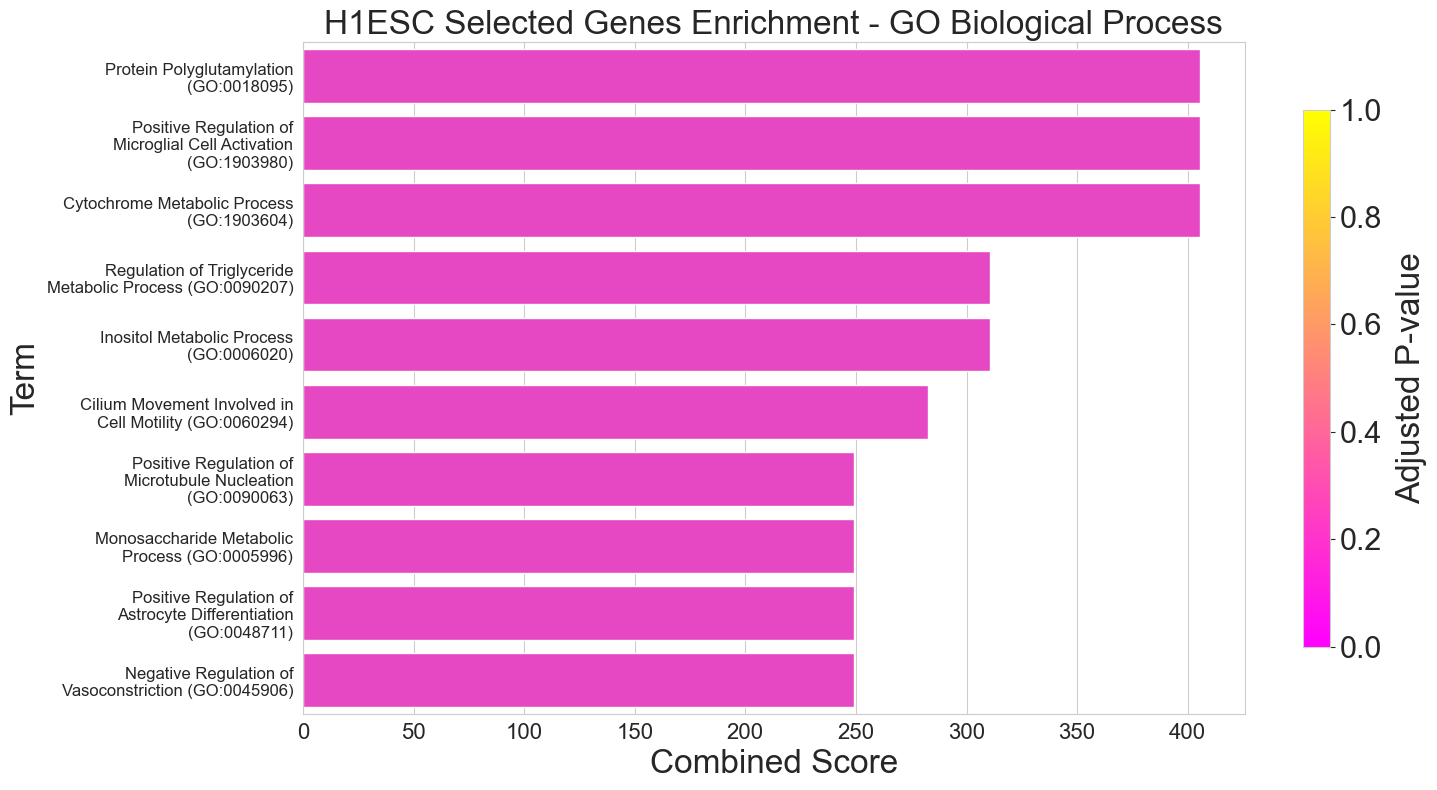

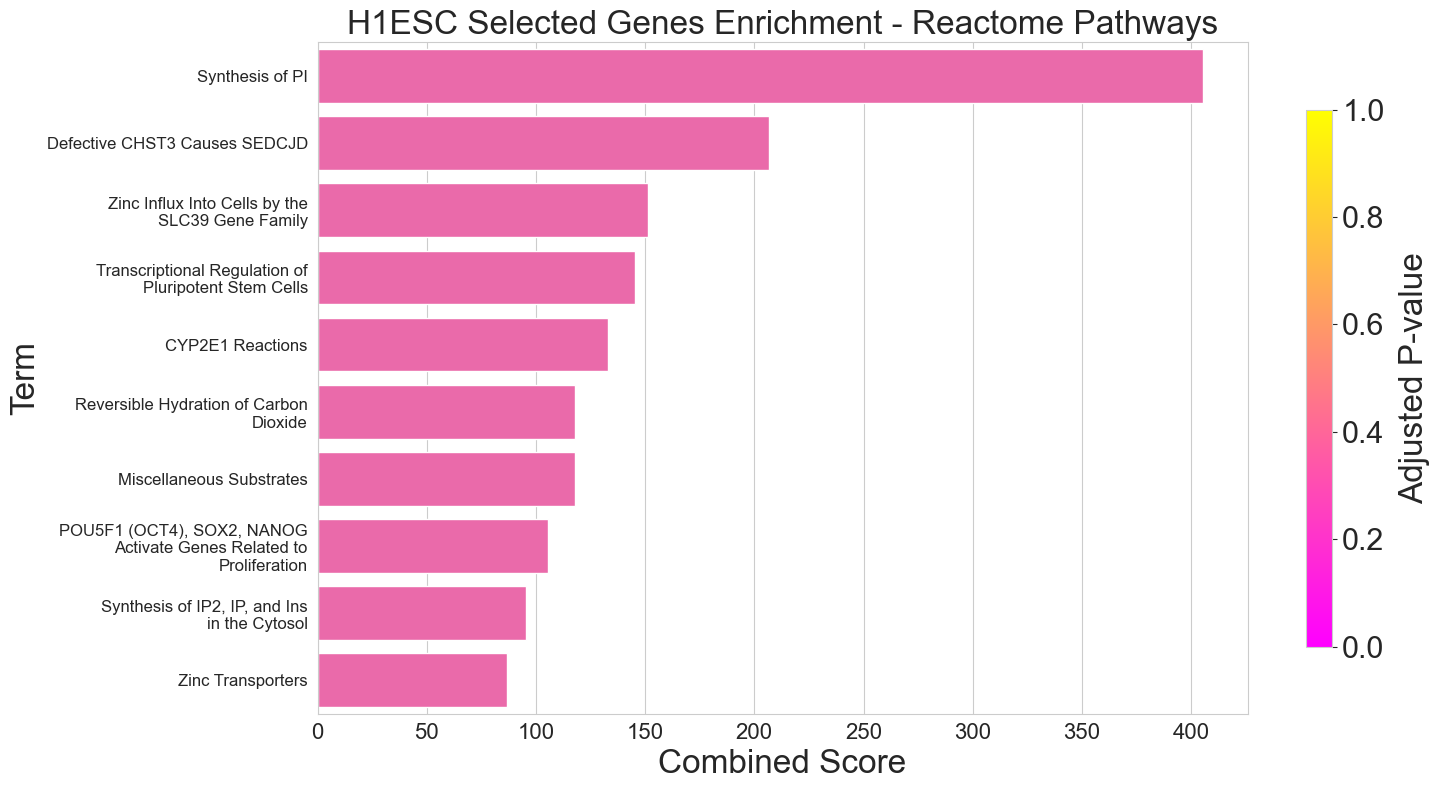

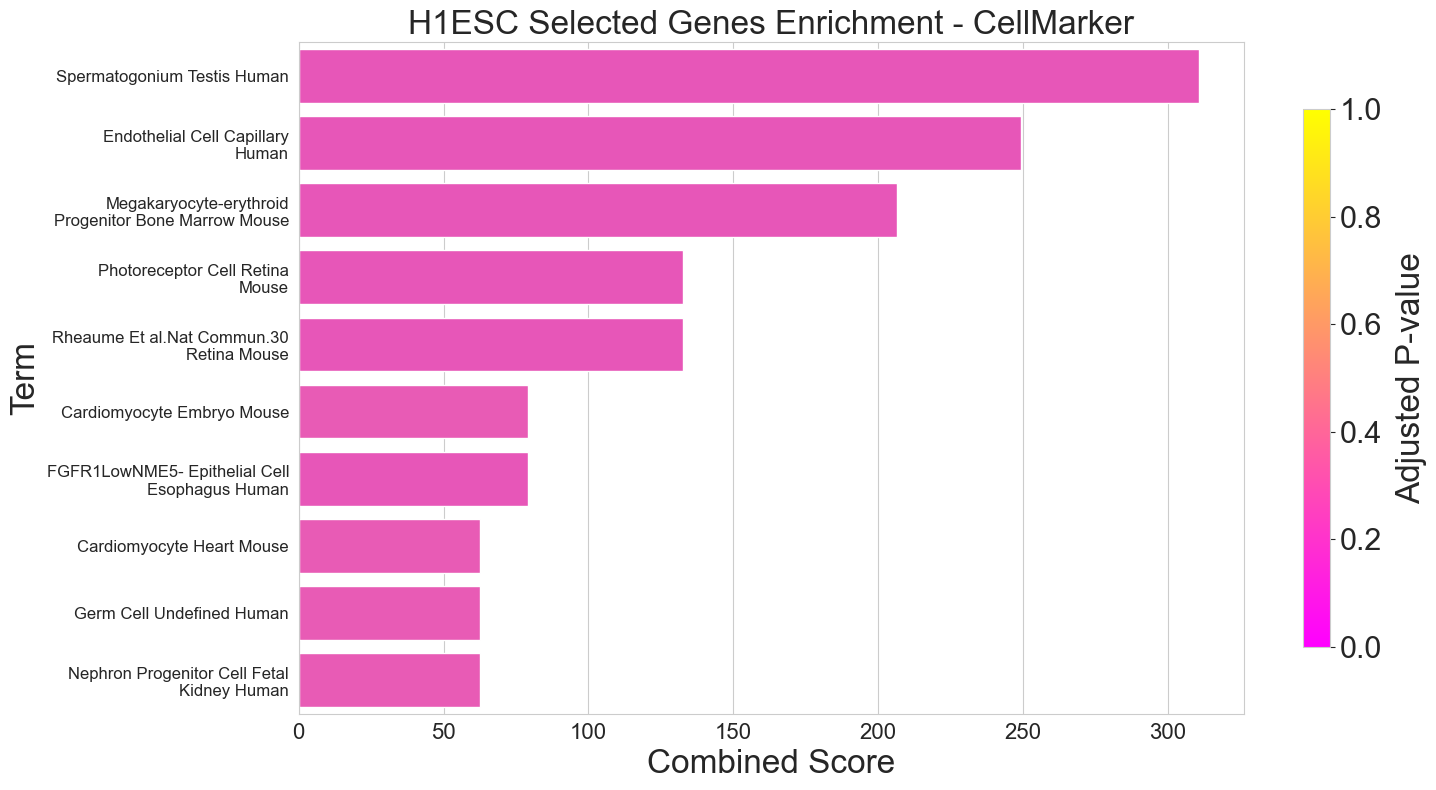

In [190]:
dotplot(get_enrichment_results(h1esc_genes, gene_sets='GO_Biological_Process_2025'), title="H1ESC Selected Genes Enrichment - GO Biological Process",
        plot_path="figs/exp4_h1esc_enrichment_go.png")
dotplot(get_enrichment_results(h1esc_genes, gene_sets='Reactome_Pathways_2024'), title="H1ESC Selected Genes Enrichment - Reactome Pathways",
        plot_path="figs/exp4_h1esc_enrichment_reactome.png")
dotplot(get_enrichment_results(h1esc_genes, gene_sets='CellMarker_2024'), title="H1ESC Selected Genes Enrichment - CellMarker",
        plot_path="figs/exp4_h1esc_enrichment_cellmarker.png")
print("H1ESC upregulated jumper genes:")
print("\n".join(gene_names_cell_line_1))

In [191]:
_, hffc6_genes, _ = get_genes_from_2_cell_lines(
    h1esc_gene_to_closest_avg_enhancer_all,
    hffc6_gene_to_closest_avg_enhancer_all,
    h1esc_vs_hffc6_results_df,
    "H1ESC",
    "HFFC6",
    log2fc_threshold=2,
    padj_threshold=0.05
)

/opt/anaconda3/envs/enhancer3D/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


/var/folders/ss/9hx8q7517rzf6x75cfny7ndc0000gp/T/ipykernel_55155/194747513.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['\n'.join(wrap(label.get_text(), width=30)) for label in ax.get_yticklabels()], fontsize=fontsize // 2)
/var/folders/ss/9hx8q7517rzf6x75cfny7ndc0000gp/T/ipykernel_55155/194747513.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['\n'.join(wrap(label.get_text(), width=30)) for label in ax.get_yticklabels()], fontsize=fontsize // 2)
/var/folders/ss/9hx8q7517rzf6x75cfny7ndc0000gp/T/ipykernel_55155/194747513.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['\n'.join(wrap(label.get_text(), width=30)) for label in ax.get_yticklabels()], fontsize=fontsiz

HFFC6 upregulated jumper genes:
SEPTIN4
RSKR
None
STOX2
HID1
MBP
UNC13D
NUP210
LRRC2
CA9
ZNF385C
ARHGEF39
SLC6A6
ADAMTS13
SYNE4
ADAMTSL2
GLDC
EFR3B
ECHDC3
NRXN3
PPFIA4
SH2D3A
TEK
NRXN2
F11R
PPP2R2B
ZNF48
CELSR2
NAALADL1
RP1L1
CLCNKA
GFPT2
ATP4A
ABRACL
HFM1
PARD6B
FAM227A
BNIPL
FBXO27
CTCFL
ZNF398
TPH2
FXYD7
ZNF232
BCL2L14
PLTP
ZSCAN23
ATF3
MAP2K6
HVCN1
ST8SIA2
ZFP57
RELL2
HEATR4
ATP6V1C2
RYR1
RIMKLB
TSGA10IP
TTBK1
GFI1B
SRSF12
CELF3
TIAM1
FCHO1
ZMAT4
FOXO6
UPK1A
ASPHD2
NKAIN3
TOGARAM2
AGPAT5
BAIAP3
CSMD1
PBX4
RASSF4
GRID2IP
ARFGEF3
SLC2A14
SNCAIP
BRME1
FAM117A
LTC4S
PDIA2
BUB1B
ADAP1
DSCC1
FAM234B
TEDC2
SLC1A3
CCDC33
ZDHHC11
FKBP1B
COBL
LPCAT1
TET3
MOGAT1
ARID3B
CACNA1H
FBXO16
SORL1
NOTCH3
HOMER2
GABRR1
CERS4
HSH2D
ZNF813
AGPAT4
SPNS2
KDR
ZNF525
None
WDR27
RPGRIP1
CCDC181
TRIM36
SYNDIG1
RYR2
DLGAP1


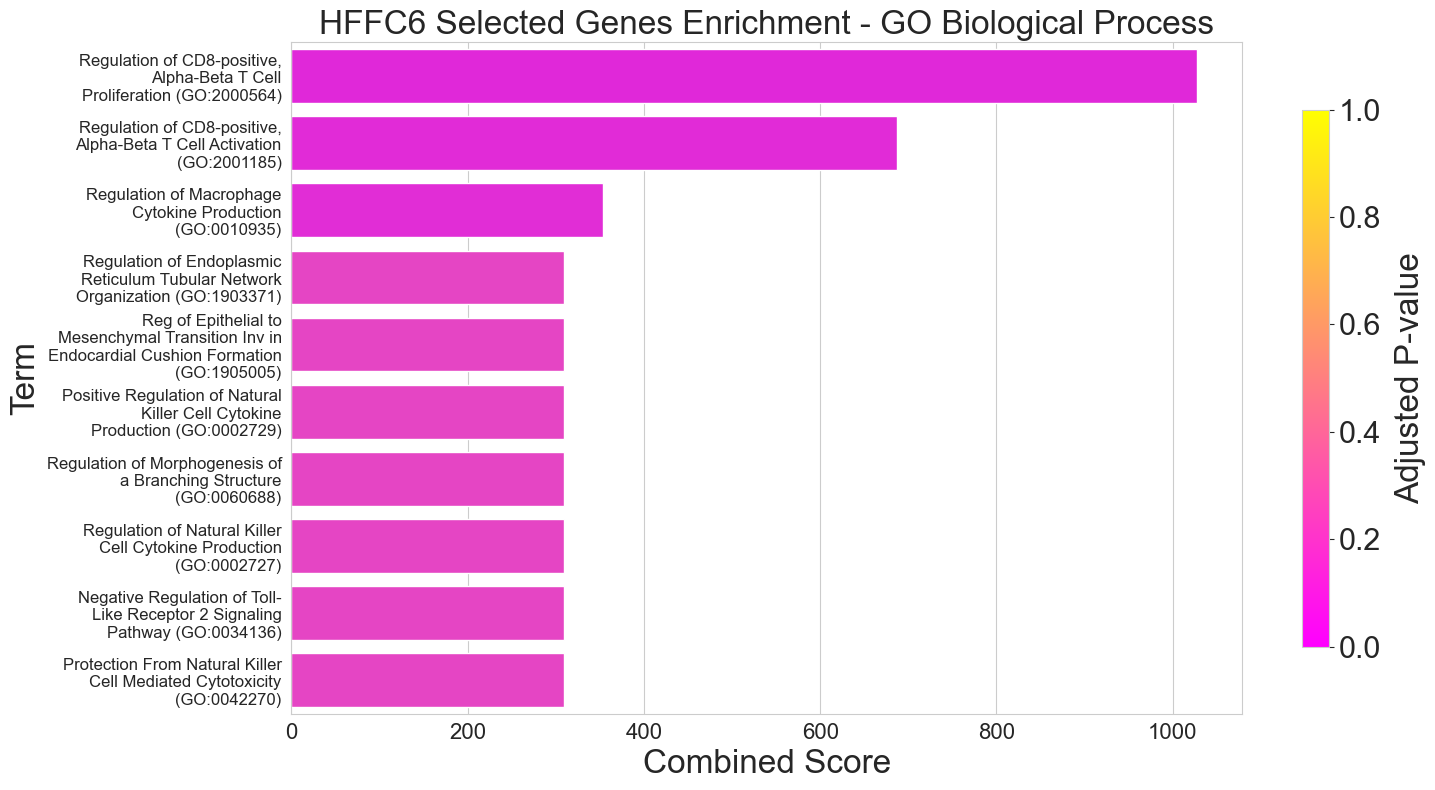

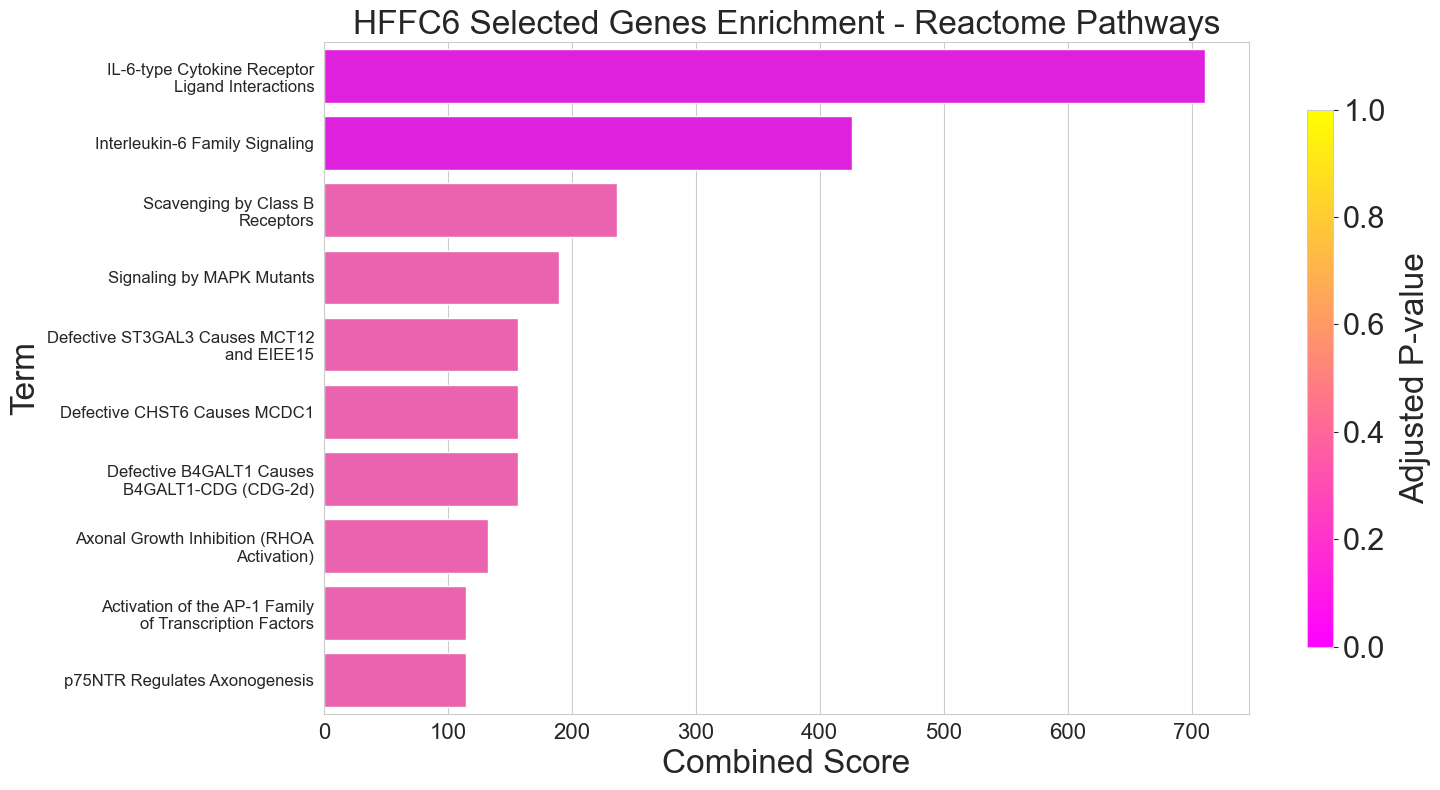

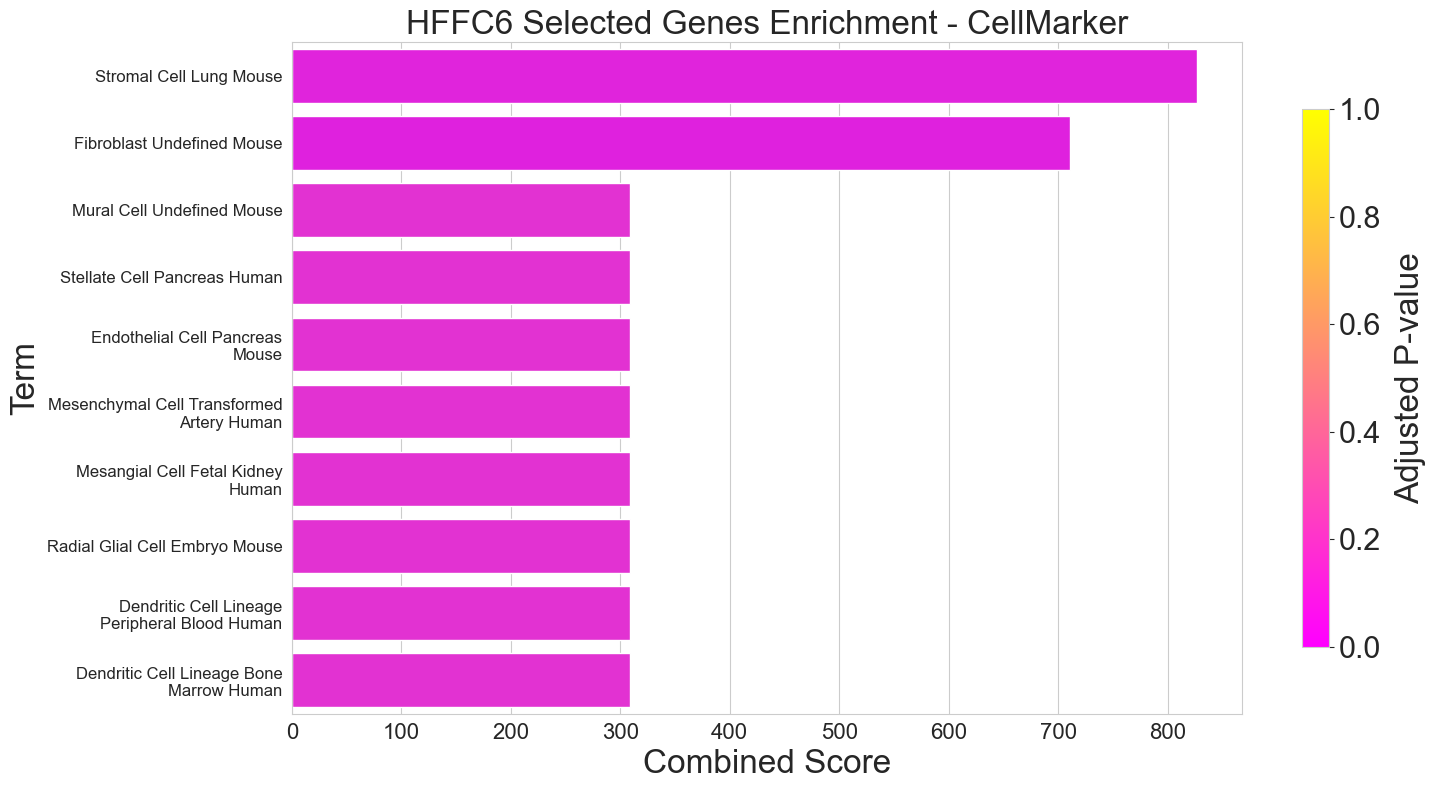

In [192]:
dotplot(get_enrichment_results(hffc6_genes, gene_sets='GO_Biological_Process_2025'), title="HFFC6 Selected Genes Enrichment - GO Biological Process",
        plot_path="figs/exp4_hffc6_enrichment_go.png")
dotplot(get_enrichment_results(hffc6_genes, gene_sets='Reactome_Pathways_2024'), title="HFFC6 Selected Genes Enrichment - Reactome Pathways",
        plot_path="figs/exp4_hffc6_enrichment_reactome.png")
dotplot(get_enrichment_results(hffc6_genes, gene_sets='CellMarker_2024'), title="HFFC6 Selected Genes Enrichment - CellMarker",
        plot_path="figs/exp4_hffc6_enrichment_cellmarker.png")
print("HFFC6 upregulated jumper genes:")
print("\n".join(gene_names_cell_line_2))

In [153]:
_, gm12878_genes, _ = get_genes_from_2_cell_lines(
    hffc6_gene_to_closest_avg_enhancer_all,
    gm12878_gene_to_closest_avg_enhancer_all,
    hffc6_vs_gm12878_results_df,
    "HFFC6",
    "GM12878",
    log2fc_threshold=2,
    padj_threshold=0.05
)

/opt/anaconda3/envs/enhancer3D/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


/var/folders/ss/9hx8q7517rzf6x75cfny7ndc0000gp/T/ipykernel_55155/194747513.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['\n'.join(wrap(label.get_text(), width=30)) for label in ax.get_yticklabels()], fontsize=fontsize // 2)
/var/folders/ss/9hx8q7517rzf6x75cfny7ndc0000gp/T/ipykernel_55155/194747513.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['\n'.join(wrap(label.get_text(), width=30)) for label in ax.get_yticklabels()], fontsize=fontsize // 2)
/var/folders/ss/9hx8q7517rzf6x75cfny7ndc0000gp/T/ipykernel_55155/194747513.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['\n'.join(wrap(label.get_text(), width=30)) for label in ax.get_yticklabels()], fontsize=fontsiz

GM12878 upregulated jumper genes:
LLGL2
NCR3
AP1G2
HINT2
MSH5
SLC7A7
VASH2
MYCBPAP
SIT1
FCMR
ITGB7
THEMIS2
SLFN12L
TRAF3IP3
TAPBPL
PSME2
CCDC69
APOA1
CD27
HMGCS1
IL23R
PITPNC1
MKNK2
RHOF
FAM111B
CRYM
EDN2
ASB2
MYO1G
IL12RB1
PATL2
RNF157
MAP3K8
FAM221A
CDH23
NCF2
SYNGR3
TP73
NFATC1
DOK3
TNFAIP8
ITPRIPL1
EVI2B


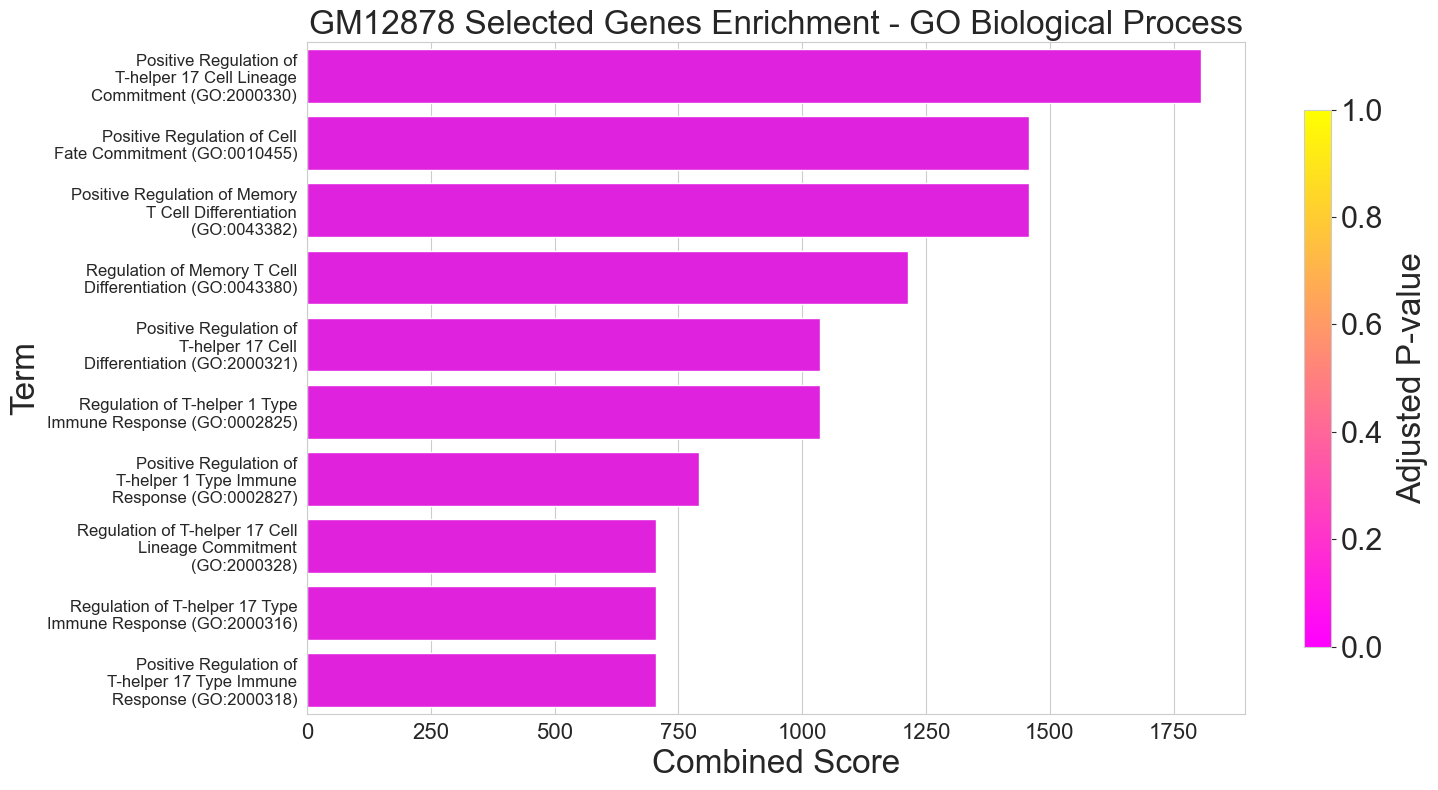

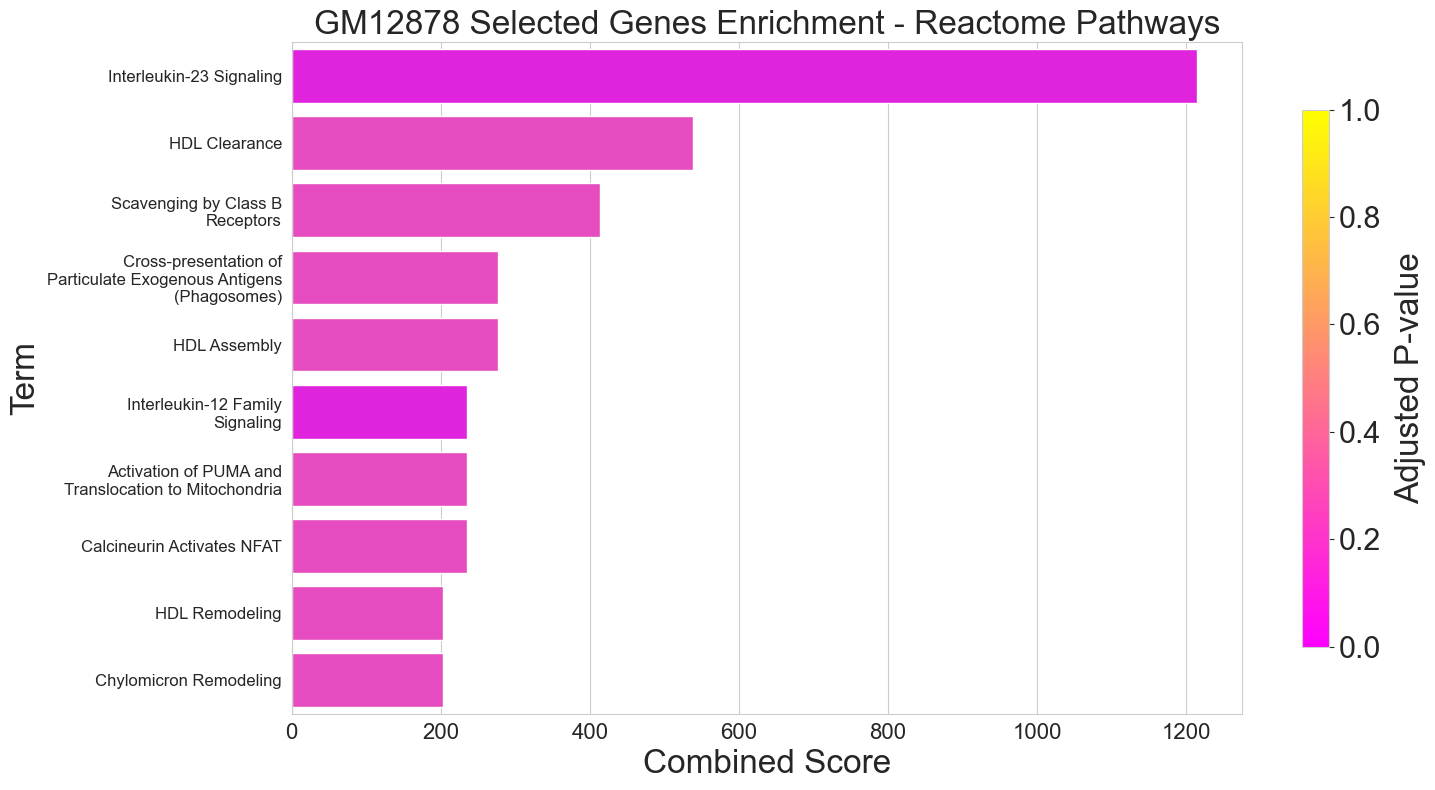

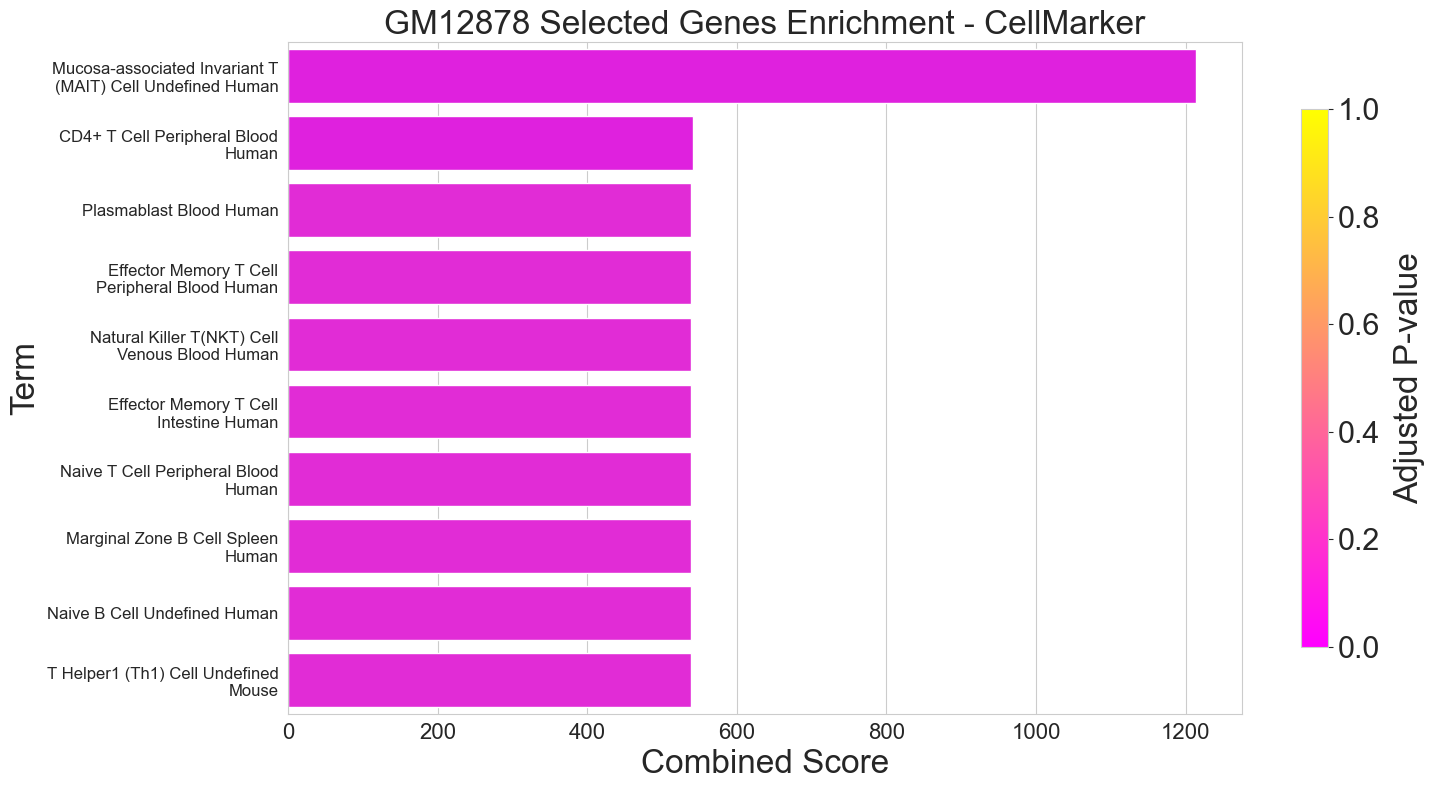

In [193]:
dotplot(get_enrichment_results(gm12878_genes, gene_sets='GO_Biological_Process_2025'), title="GM12878 Selected Genes Enrichment - GO Biological Process", plot_path="figs/exp4_gm12878_enrichment_go.png")
dotplot(get_enrichment_results(gm12878_genes, gene_sets='Reactome_Pathways_2024'), title="GM12878 Selected Genes Enrichment - Reactome Pathways", plot_path="figs/exp4_gm12878_enrichment_reactome.png")
dotplot(get_enrichment_results(gm12878_genes, gene_sets='CellMarker_2024'), title="GM12878 Selected Genes Enrichment - CellMarker", plot_path="figs/exp4_gm12878_enrichment_cellmarker.png")
print("GM12878 upregulated jumper genes:")
print("\n".join(gm12878_genes))